## WSI Level Classification on BACH Part B (WSIs)
### Specs:
- EfficientNetb0
- PCA
- NO Self Attention
- 20 epochs, lr=0.000025
- Classes = 'Benign or Insitu Carcinoma', 'Invasive Carcinoma'
- Pos_weight = 0.6 (invasive carcinoma)

In [1]:
# importing necessary libraries 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision 
from torchvision import transforms, datasets, models 
from torch.nn import functional as F 
from PIL import Image
import pandas as pd 
import numpy as np
import tensorflow as tf
import os
import sys
import glob
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt 
import cv2
import json 
from tqdm import tqdm
from sklearn.decomposition import PCA 
from sklearn.preprocessing import StandardScaler
from skimage.transform import rotate, AffineTransform
import random
from scipy import ndimage
import openslide
import matplotlib.patches as patches
from matplotlib.patches import Polygon
import xml.etree.ElementTree as ET 
import seaborn as sns
from sklearn.metrics import confusion_matrix
from collections import defaultdict
# Setting random seed for reproducibility
torch.manual_seed(42)

**LOADING PATCH EMBEDDINGS** 

In [2]:
patch_features = torch.load('/kaggle/input/bach-dataset-patches/512x512 patches (resized)/512x512 patches (resized)/Other Regions/patch_embeddings.pth') 

/tmp/ipykernel_30/474803886.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  patch_features = torch.load('/kaggle/input/bach-dataset-patches/512x512 patches (resized)/512

# Defining Autoencoder model
class Autoencoder(nn.Module):
    def __init__(self, input_size, encoding_dim):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
           nn.Linear(input_size, 16),
           nn.ReLU(),
           nn.Linear(16, encoding_dim),
           nn.ReLU()
        )
        self.decoder = nn.Sequential(
           nn.Linear(encoding_dim, 16),
           nn.ReLU(),
           nn.Linear(16, input_size),
           nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
# Combining feature maps for PCA 


scaler = StandardScaler()
X_scaled = scaler.fit_transform(patch_features)

X_tensor = torch.FloatTensor(X_scaled)

input_size = 1000  # Number of input features
encoding_dim = 224  # Desired number of output dimensions
model = Autoencoder(input_size, encoding_dim)

# Loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0003)

# Training the autoencoder
num_epochs = 20
for epoch in range(num_epochs):
    # Forward pass
    outputs = model(X_tensor)
    loss = criterion(outputs, X_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Loss for each epoch
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {loss.item():.4f}')


In [3]:
# Encoding the data using the trained autoencoder
#encoded_features = model.encoder(X_tensor).detach().numpy()
# function to apply PCA to reduce dimensions to 500 

def getPCA(feature_map, n):
    pca = PCA(n_components = n)
    pca.fit(feature_map)
    return pca.transform(feature_map) 
# applying PCA 

encoded_features = getPCA(patch_features, 224) 

**LOADING PATCH DATA** 

In [4]:
# reading patients' data 

df = pd.read_csv('/kaggle/input/bach-dataset-patches/512x512 patches (resized)/512x512 patches (resized)/Other Regions/patch_info.csv')

# Rename specific values in the 'Label' column
df['Label'] = df['Label'].replace({
    'Carcinoma invasive': 'Invasive carcinoma',
    'Carcinoma in situ': 'In situ carcinoma'
})
df.dropna(inplace = True)
df.head() 

,WSI Id,Annotation No.,X Start Pixel,Y Start Pixel,White Area %,Label
0,0,1,7332,21574,23.711777,Benign
1,0,1,7716,21574,25.470352,Benign
2,0,1,7332,21958,39.041519,Benign
3,0,1,7716,21958,48.205948,Benign
4,0,2,8234,20980,23.772049,Benign


<Axes: xlabel='Label'>

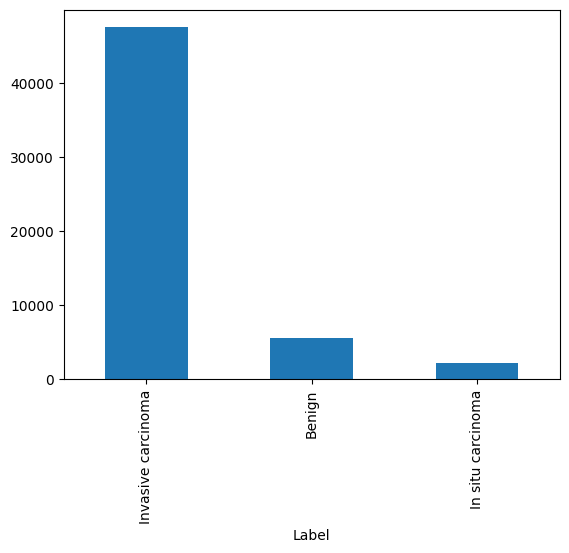

In [5]:
df['Label'].value_counts().plot.bar()

In [6]:
# filtering out excessively white patches 

#df = df[df['White Area %'] < 90] 

In [7]:
# filtering out first 5 WSIs for train, next 2 for validation, and the last 3 for test datasets 

train_df = df[(df['WSI Id'] == 'A01') | (df['WSI Id'] == 'A02') | (df['WSI Id'] == 'A03') | (df['WSI Id'] == 'A04') | (df['WSI Id'] == 'A05')].reset_index(drop=True)
mask = (df['WSI Id'] == 'A01') | (df['WSI Id'] == 'A02') | (df['WSI Id'] == 'A03') | (df['WSI Id'] == 'A04') | (df['WSI Id'] == 'A05') 
encoded_feats_train = [encoded_features[i] for i in range(len(encoded_features)) if mask.iloc[i]] 

val_df = df[(df['WSI Id'] == 'A06') | (df['WSI Id'] == 'A07')].reset_index(drop=True)
mask = (df['WSI Id'] == 'A06') | (df['WSI Id'] == 'A07') 
encoded_feats_val = [encoded_features[i] for i in range(len(encoded_features)) if mask.iloc[i]]

test_df = df[(df['WSI Id'] == 'A08') | (df['WSI Id'] == 'A09') | (df['WSI Id'] == 'A10')].reset_index(drop=True)
mask = (df['WSI Id'] == 'A08') | (df['WSI Id'] == 'A09') | (df['WSI Id'] == 'A10') 
encoded_feats_test = [encoded_features[i] for i in range(len(encoded_features)) if mask.iloc[i]]

In [8]:
# obtaining patient ids / wsi nos, annotation nos. & and labels 

train_wsi_nos = list(train_df['WSI Id']) 
train_ann_nos = list(train_df['Annotation No.']) 
train_labels = list(train_df['Label']) 

val_wsi_nos = list(val_df['WSI Id']) 
val_ann_nos = list(val_df['Annotation No.']) 
val_labels = list(val_df['Label']) 

test_wsi_nos = list(test_df['WSI Id']) 
test_ann_nos = list(test_df['Annotation No.']) 
test_labels = list(test_df['Label']) 

**LOADING EXTRA NORMAL PATCH EMBEDDINGS** 

In [9]:
norm_patch_feats = torch.load('/kaggle/input/bach-dataset-patches/512x512 patches (resized)/512x512 patches (resized)/Extra Normal/patch_embeddings.pth') 

/tmp/ipykernel_30/4084494481.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  norm_patch_feats = torch.load('/kaggle/input/bach-dataset-patches/512x512 patches (resized)/

# applying auto encoder 
X_scaled_norm = scaler.transform(norm_patch_feats)

X_tensor_norm = torch.FloatTensor(X_scaled_norm)
norm_encoded_features = model.encoder(X_tensor_norm).detach().numpy()

In [10]:
norm_encoded_features = getPCA(norm_patch_feats, 224) 

**LOADING EXTRA NORMAL REGION DATA** 

In [11]:
# reading patients' data 

norm_df = pd.read_csv('/kaggle/input/bach-dataset-patches/512x512 patches (resized)/512x512 patches (resized)/Extra Normal/patch_info.csv')
norm_df.dropna(inplace = True)
norm_df.head() 

,WSI Id,Annotation No.,X Start Pixel,Y Start Pixel,White Area %,Label
0,A01,1,33571,2449,59.221540,Normal
1,A01,1,33739,2449,57.029257,Normal
2,A01,1,33907,2449,74.382175,Normal
3,A01,1,34075,2449,87.559790,Normal
4,A01,1,34243,2449,89.349490,Normal


In [12]:
# dictionary containing current annotation counts for WSIs 

curr_ann_count = { 'A01': 40, 'A02': 17, 'A03': 10, 'A04': 1, 
                'A05': 15, 'A06': 6, 'A07': 7, 'A08': 92, 'A09': 29, 'A10': 9 } 

In [13]:
# updating the 'Annotation No.' column by adding the corresponding value from the dictionary 

norm_df['Annotation No.'] = norm_df.apply(
    lambda row: row['Annotation No.'] + curr_ann_count.get(row['WSI Id'], 0), axis=1
) 

norm_df.head() 

,WSI Id,Annotation No.,X Start Pixel,Y Start Pixel,White Area %,Label
0,A01,41,33571,2449,59.221540,Normal
1,A01,41,33739,2449,57.029257,Normal
2,A01,41,33907,2449,74.382175,Normal
3,A01,41,34075,2449,87.559790,Normal
4,A01,41,34243,2449,89.349490,Normal


In [14]:
# filtering out first 5 WSIs for train, next 2 for validation, and the last 3 for test datasets 

norm_train_df = norm_df[(norm_df['WSI Id'] == 'A01') | (norm_df['WSI Id'] == 'A02') | (norm_df['WSI Id'] == 'A03') | (norm_df['WSI Id'] == 'A04') | (norm_df['WSI Id'] == 'A05')].reset_index(drop=True)
mask = (norm_df['WSI Id'] == 'A01') | (norm_df['WSI Id'] == 'A02') | (norm_df['WSI Id'] == 'A03') | (norm_df['WSI Id'] == 'A04') | (norm_df['WSI Id'] == 'A05') 
norm_encoded_feats_train = [norm_encoded_features[i] for i in range(len(norm_encoded_features)) if mask.iloc[i]] 

norm_val_df = norm_df[(norm_df['WSI Id'] == 'A06') | (norm_df['WSI Id'] == 'A07')].reset_index(drop=True)
mask = (norm_df['WSI Id'] == 'A06') | (norm_df['WSI Id'] == 'A07') 
norm_encoded_feats_val = [norm_encoded_features[i] for i in range(len(norm_encoded_features)) if mask.iloc[i]]

norm_test_df = norm_df[(norm_df['WSI Id'] == 'A08') | (norm_df['WSI Id'] == 'A09') | (norm_df['WSI Id'] == 'A10')].reset_index(drop=True)
mask = (norm_df['WSI Id'] == 'A08') | (norm_df['WSI Id'] == 'A09') | (norm_df['WSI Id'] == 'A10') 
norm_encoded_feats_test = [norm_encoded_features[i] for i in range(len(norm_encoded_features)) if mask.iloc[i]]


In [15]:
# obtaining patient ids / wsi nos, annotation nos. & and labels 

norm_train_wsi_nos = list(norm_train_df['WSI Id']) 
norm_train_ann_nos = list(norm_train_df['Annotation No.']) 
norm_train_labels = list(norm_train_df['Label']) 

norm_val_wsi_nos = list(norm_val_df['WSI Id']) 
norm_val_ann_nos = list(norm_val_df['Annotation No.']) 
norm_val_labels = list(norm_val_df['Label']) 

norm_test_wsi_nos = list(norm_test_df['WSI Id']) 
norm_test_ann_nos = list(norm_test_df['Annotation No.']) 
norm_test_labels = list(norm_test_df['Label']) 

**MERGING OLD DATA & NEW EXTRA NORMAL DATA** 

In [16]:
# concatenating all essential lists 

train_wsi_nos.extend(norm_train_wsi_nos) 
train_ann_nos.extend(norm_train_ann_nos) 
train_labels.extend(norm_train_labels) 
encoded_feats_train.extend(norm_encoded_feats_train) 

val_wsi_nos.extend(norm_val_wsi_nos) 
val_ann_nos.extend(norm_val_ann_nos) 
val_labels.extend(norm_val_labels) 
encoded_feats_val.extend(norm_encoded_feats_val) 

test_wsi_nos.extend(norm_test_wsi_nos) 
test_ann_nos.extend(norm_test_ann_nos) 
test_labels.extend(norm_test_labels) 
encoded_feats_test.extend(norm_encoded_feats_test) 

**BAG FORMATION** 

In [17]:
# Function to create and return bags (1 bag / annotation) for each dataset 

def create_bags(wsis, anns, labels_, feature_maps, min_patches, max_patches): 
    
    bags = [] 
    labels = [] 
    
    wsis_against_bags = []  # list to maintain wsi numbers against bags 
    anns_against_bags = []
    
    count = 0 
    extra_bags = 0 
    
    discarded_anns = 0 
    total_anns = 0 
    
    total_wsis = 1 
    discarded_wsis = 0 
    prev_wsi_len = 0 
    
    i = 0 
    other_reserve = [] 
    invasive_reserve = [] 
    
    # loop to traverse through each WSI 
    while (i < len(wsis)): 
        
        curr_wsi = wsis[i] 
        bag = [] 
        curr_ann = anns[i] 
        
        # initial length of bag before traversing through annotation 
        prev_len = len(bags) 
        
        # loop to traverse through each annotation 
        while (i < len(anns) and curr_ann == anns[i] and curr_wsi == wsis[i]): 
            curr_ann = anns[i] 
            bag.append(feature_maps[i]) 
            i += 1 
        
        # minimum number of patches in a bag to keep it 
        if len(bag) >= min_patches: 
            # maximum number of patches in a bag before splitting it 
            if len(bag) < max_patches: 
                bags.append(bag) 
                if labels_[i - 1] == 'Benign' or labels_[i - 1] == 'Normal': 
                    labels.append(0) 
                else: 
                    labels.append(1) 
                wsis_against_bags.append(curr_wsi) 
                anns_against_bags.append(curr_ann)
            
            else: 
                x = 0 
                while (x + max_patches) < len(bag): 
                    bags.append(bag[x : x + max_patches]) 
                    if labels_[i - 1] == 'Benign' or labels_[i - 1] == 'Normal': 
                        labels.append(0) 
                    else: 
                        labels.append(1) 
                    wsis_against_bags.append(curr_wsi) 
                    anns_against_bags.append(curr_ann)
                    x += max_patches 
        
        # len(bag) < min patches 
        else: 
            if i < len(wsis) and wsis[i] == curr_wsi: 
                #print("Labels_[i - 1]", labels_[i-1])
                if labels_[i - 1] == 'Benign' or labels_[i - 1] == 'Normal': 
                    other_reserve.extend(bag) 
                if labels_[i - 1] == 'Invasive carcinoma':
                    invasive_reserve.extend(bag) 
        
        # new length of bag after traversing through annotation 
        new_len = len(bags) 
        
        # new wsi 
        if i < len(wsis) and wsis[i] != curr_wsi: 

            extra_bags_size = int(min_patches * (1)) 
            
            x = 0 
            # Loop to off load all three reserves once done with a given wsi (min_patches x 2 instances in each extra bag) 
            
            # Benign reserve offload
            while (x + extra_bags_size) <= len(other_reserve): 
                extra_bags += 1 
                bags.append(other_reserve[x : x + extra_bags_size]) 
                if labels_[i - 1] == 'Benign' or labels_[i - 1] == 'Normal': 
                    labels.append(0) 
                else: 
                    labels.append(1) 
                wsis_against_bags.append(curr_wsi) 
                anns_against_bags.append(curr_ann)
                x += extra_bags_size 
                
            # Invasive reserve offload
            while (x + extra_bags_size) <= len(invasive_reserve): 
                extra_bags += 1 
                bags.append(invasive_reserve[x : x + extra_bags_size]) 
                if labels_[i - 1] == 'Benign' or labels_[i - 1] == 'Normal': 
                    labels.append(0) 
                else: 
                    labels.append(1) 
                wsis_against_bags.append(curr_wsi) 
                anns_against_bags.append(curr_ann)
                x += extra_bags_size 
                
            # refresh reserves for next wsi 
            other_reserve = [] 
            invasive_reserve = [] 
            
            # if wsi discarded 
            total_wsis += 1 
            if len(bags) == prev_wsi_len: 
                discarded_wsis += 1 
            prev_wsi_len = len(bags) 
        
        # if annotation discarded 
        if prev_len == new_len: 
            discarded_anns += 1 
        total_anns += 1 
    
    # calculating percentage of discarded wsis for a given min_patches value 
    perc_wsis_discarded = discarded_wsis / total_wsis 
    
    return bags, labels, extra_bags, perc_wsis_discarded, wsis_against_bags, anns_against_bags

In [18]:
set(train_labels)

{'Benign', 'In situ carcinoma', 'Invasive carcinoma', 'Normal'}

In [19]:
# creating bags 

train_bags, train_bag_labels, _, _, train_wsis_for_bags, train_anns_for_bags = create_bags(train_wsi_nos, train_ann_nos, train_labels, encoded_feats_train, 50, 224) 
val_bags, val_bag_labels, _, _, val_wsis_for_bags, val_anns_for_bags = create_bags(val_wsi_nos, val_ann_nos, val_labels, encoded_feats_val, 50, 224) 
test_bags, test_bag_labels, _, _, test_wsis_for_bags, test_anns_for_bags = create_bags(test_wsi_nos, test_ann_nos, test_labels, encoded_feats_test, 50, 224) 

In [20]:
print(len(train_bags))
print(len(train_bags[0]))
print(len(train_bags[0][0])) 

print('\n', len(val_bags))
print(len(val_bags[0]))
print(len(val_bags[0][0])) 

print('\n', len(test_bags))
print(len(test_bags[0]))
print(len(test_bags[0][0])) 

365
224
224

 119
224
224

 168
56
224


**CLASS DISTRIBUTION** 

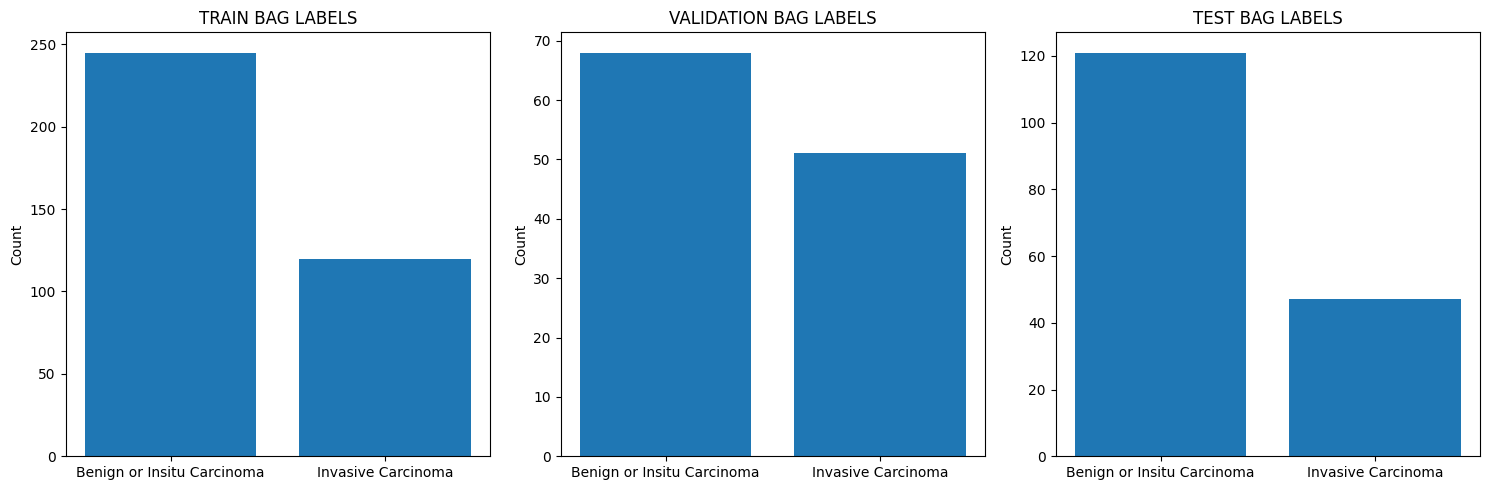

In [21]:
import matplotlib.pyplot as plt

# class distribution of train, validation, and test datasets 

def plot_bag_labels(ax, title, labels): 
    
    # Count occurrences of each class
    class_counts = [labels.count(i) for i in range(2)]
    
    # Plot the distribution
    ax.bar(['Benign or Insitu Carcinoma', 'Invasive Carcinoma'], class_counts)
    ax.set_title(title)
    ax.set_ylabel('Count')

# Plotting
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

plot_bag_labels(axs[0], 'TRAIN BAG LABELS', train_bag_labels)
plot_bag_labels(axs[1], 'VALIDATION BAG LABELS', val_bag_labels)
plot_bag_labels(axs[2], 'TEST BAG LABELS', test_bag_labels)

plt.tight_layout()
plt.show()

**CUSTOM DATASETS** 

In [22]:
# Custom dataset to load feature vectors & binary class labels 

class CustomDataset(Dataset):
    def __init__(self, bags, labels):
        self.bags = bags
        self.labels = labels

    def __len__(self):
        return len(self.bags)

    def __getitem__(self, idx):
        
        x = self.bags[idx]
        if len(x) > 224:
            feat_map = x[:224]
        else:
            feat_map = []
            feat_map.extend([np.array([0.0] * 224)] * int((224 - len(x)) / 2)) # black padding above
            feat_map.extend(x) # feature map of patches in between
            feat_map.extend([np.array([0.0] * 224)] * int(((224 - len(x)) / 2) + 1)) # black padding below
            feat_map = feat_map[:224]
        
        x = np.array(feat_map) 
        
        x = torch.tensor(x).float()
        x = nn.functional.normalize(x, dim=0, p=2)  # p=2 for L2 norm, dim=0 for cols
        bag = x
        label = self.labels[idx]
        label = torch.tensor(label)
        
        return torch.stack([bag]), label

In [23]:
# Create instances of custom datasets

train_dataset = CustomDataset(train_bags, train_bag_labels)
valid_dataset = CustomDataset(val_bags, val_bag_labels)
test_dataset = CustomDataset(test_bags, test_bag_labels)

In [24]:
train_bag_labels[:3]

[0, 0, 1]

**DATA LOADERS** 

In [25]:
batch_size = 16  

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers = 0)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, num_workers = 0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers = 0)

In [26]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

**FINAL MODEL** 

In [27]:
from torch.nn import functional as F
import torchvision.models as models

class Pipeline(nn.Module):
    def __init__(self,num_classes):
        #define necessary layers
        super().__init__()
        self.num_classes = num_classes
          
        self.base = models.vit_b_32()#(weights=True)
        # Unfreeze model weights
        for param in self.base.parameters():
            param.requires_grad = True
        
        self.flatten = nn.Flatten()
        
        self.head = nn.Sequential(
            nn.Linear(1000, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        ) 
    
    def attention(self, query, key, value, mask=None, dropout=None):
        "Compute 'Scaled Dot Product Attention'"
        d_k = query.size(-1)
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(d_k)
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        p_attn = scores.softmax(dim=-1)
        if dropout is not None:
            p_attn = dropout(p_attn)
        return torch.matmul(p_attn, value), p_attn
    
    def forward(self,X):
        attended_values, attention_scores = self.attention(X, X, X)
        X = self.base(X)
        X = self.flatten(X)
        X = self.head(X)
        return X, F.sigmoid(X)

pos_weight = torch.tensor([0.6])
pos_weight = pos_weight.to(device)
loss_fn = nn.BCEWithLogitsLoss(pos_weight = pos_weight)
model = Pipeline(1)
#model = nn.DataParallel(model)

In [28]:
# modifying first layer for one color channel 
# for efficientnetb0
#model.base.features[0][0] = nn.Conv2d(1, 32,kernel_size= (3,3), stride = 2, padding= 1, bias=False)

# for resnet50
#model.base.conv1=nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)

#for VIT
model.base.conv_proj = nn.Conv2d(1, 768, kernel_size=(32, 32), stride=(32, 32))

In [29]:
# Check if GPU is available
if torch.cuda.is_available():
    model = model.to(device)
    print('available')

#criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params=model.parameters(), lr=0.000025)

available


In [30]:
!export CUDA_LAUNCH_BLOCKING=1

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


**TRAINING** 

In [31]:
# Initialize empty lists to store loss and accuracy for training and validation
train_losses = []
valid_losses = []
train_accuracies = []
valid_accuracies = []
roc_values_train = []
roc_values_val = []

In [32]:
from sklearn.metrics import roc_curve, auc, classification_report
import math  

# Training loop
num_epochs = 20  # Adjust as needed

In [33]:


for epoch in range(num_epochs):
    model.train()
    y_true_train = []
    y_scores_train = []
    train_loss = 0
    correct = 0
    total = 0
    for images, labels in tqdm(train_loader):
        # Move data to GPU if available
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs_without_sigmoid, outputs_with_sigmoid = model(images)
        loss = loss_fn(outputs_without_sigmoid.squeeze(-1), labels.float())
        loss.backward()
        optimizer.step()
        train_loss += loss.item()  # L+=l.item()
        predicted = (outputs_with_sigmoid >= 0.5).long().squeeze(-1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        y_true_train.extend(labels.cpu().detach().numpy())
        y_scores_train.extend(outputs_with_sigmoid.cpu().detach().numpy())

    train_losses.append(train_loss / len(train_loader))
    train_accuracies.append(100 * correct / total)

    # roc auc logic
    fpr_train, tpr_train, _ = roc_curve(y_true_train, y_scores_train)
    roc_auc_train = auc(fpr_train, tpr_train)
    roc_values_train.append(roc_auc_train)

    # Plot ROC curve for the training set

    # Validate your model after each epoch if needed
    model.eval()
    valid_loss = 0
    correct = 0
    total = 0
    y_true_val = []
    y_scores_val = []
    with torch.no_grad():
        for images, labels in tqdm(valid_loader):
            # Move data to GPU if available
            images = images.to(device)
            labels = labels.to(device)
            outputs_without_sigmoid, outputs_with_sigmoid = model(images)
            loss = loss_fn(outputs_without_sigmoid.squeeze(-1), labels.float())
            valid_loss += loss.item()  # L+=l.item()
            predicted = (outputs_with_sigmoid >= 0.5).long().squeeze(-1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            y_true_val.extend(labels.cpu().detach().numpy())
            y_scores_val.extend(outputs_with_sigmoid.cpu().detach().numpy())

    valid_losses.append(valid_loss / len(valid_loader))
    valid_accuracies.append(100 * correct / total)
    # roc auc logic
    fpr_val, tpr_val, _ = roc_curve(y_true_val, y_scores_val)
    roc_auc_val = auc(fpr_val, tpr_val)
    roc_values_val.append(roc_auc_val)

    # Classification report
    print(f'Epoch {epoch + 1}, Train Accuracy: {train_accuracies[-1]:.2f}%, Train Loss: {train_losses[-1]:.2f}%, Train ROC-AUC: {roc_auc_train:.2f}%, Val Accuracy: {valid_accuracies[-1]:.2f}%, Val Loss: {valid_losses[-1]:.2f}%, Val ROC-AUC: {roc_auc_val:.2f}%')

    y_true_val = np.array(y_true_val)
    y_pred_val = (np.array(y_scores_val) >= 0.5).astype(int)
    print("Validation Classification Report:")
    print(classification_report(y_true_val, y_pred_val,zero_division=1))

100%|██████████| 8/8 [00:00<00:00, 29.72it/s]


Epoch 1, Train Accuracy: 63.56%, Train Loss: 0.58%, Train ROC-AUC: 0.53%, Val Accuracy: 57.14%, Val Loss: 0.54%, Val ROC-AUC: 0.53%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        68
           1       1.00      0.00      0.00        51

    accuracy                           0.57       119
   macro avg       0.79      0.50      0.36       119
weighted avg       0.76      0.57      0.42       119



100%|██████████| 8/8 [00:00<00:00, 30.39it/s]


Epoch 2, Train Accuracy: 67.12%, Train Loss: 0.51%, Train ROC-AUC: 0.49%, Val Accuracy: 57.14%, Val Loss: 0.50%, Val ROC-AUC: 0.46%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        68
           1       1.00      0.00      0.00        51

    accuracy                           0.57       119
   macro avg       0.79      0.50      0.36       119
weighted avg       0.76      0.57      0.42       119



100%|██████████| 8/8 [00:00<00:00, 30.51it/s]


Epoch 3, Train Accuracy: 67.12%, Train Loss: 0.47%, Train ROC-AUC: 0.50%, Val Accuracy: 57.14%, Val Loss: 0.51%, Val ROC-AUC: 0.42%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        68
           1       1.00      0.00      0.00        51

    accuracy                           0.57       119
   macro avg       0.79      0.50      0.36       119
weighted avg       0.76      0.57      0.42       119



100%|██████████| 8/8 [00:00<00:00, 30.32it/s]


Epoch 4, Train Accuracy: 67.12%, Train Loss: 0.47%, Train ROC-AUC: 0.47%, Val Accuracy: 57.14%, Val Loss: 0.52%, Val ROC-AUC: 0.42%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        68
           1       1.00      0.00      0.00        51

    accuracy                           0.57       119
   macro avg       0.79      0.50      0.36       119
weighted avg       0.76      0.57      0.42       119



100%|██████████| 8/8 [00:00<00:00, 30.22it/s]


Epoch 5, Train Accuracy: 67.12%, Train Loss: 0.47%, Train ROC-AUC: 0.52%, Val Accuracy: 57.14%, Val Loss: 0.52%, Val ROC-AUC: 0.39%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        68
           1       1.00      0.00      0.00        51

    accuracy                           0.57       119
   macro avg       0.79      0.50      0.36       119
weighted avg       0.76      0.57      0.42       119



100%|██████████| 8/8 [00:00<00:00, 30.63it/s]


Epoch 6, Train Accuracy: 77.26%, Train Loss: 0.40%, Train ROC-AUC: 0.77%, Val Accuracy: 57.14%, Val Loss: 0.56%, Val ROC-AUC: 0.62%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        68
           1       1.00      0.00      0.00        51

    accuracy                           0.57       119
   macro avg       0.79      0.50      0.36       119
weighted avg       0.76      0.57      0.42       119



100%|██████████| 8/8 [00:00<00:00, 30.04it/s]


Epoch 7, Train Accuracy: 67.12%, Train Loss: 0.48%, Train ROC-AUC: 0.47%, Val Accuracy: 57.14%, Val Loss: 0.51%, Val ROC-AUC: 0.61%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        68
           1       1.00      0.00      0.00        51

    accuracy                           0.57       119
   macro avg       0.79      0.50      0.36       119
weighted avg       0.76      0.57      0.42       119



100%|██████████| 8/8 [00:00<00:00, 30.68it/s]


Epoch 8, Train Accuracy: 67.12%, Train Loss: 0.47%, Train ROC-AUC: 0.48%, Val Accuracy: 57.14%, Val Loss: 0.51%, Val ROC-AUC: 0.39%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        68
           1       1.00      0.00      0.00        51

    accuracy                           0.57       119
   macro avg       0.79      0.50      0.36       119
weighted avg       0.76      0.57      0.42       119



100%|██████████| 8/8 [00:00<00:00, 30.57it/s]


Epoch 9, Train Accuracy: 67.12%, Train Loss: 0.47%, Train ROC-AUC: 0.52%, Val Accuracy: 57.14%, Val Loss: 0.51%, Val ROC-AUC: 0.38%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        68
           1       1.00      0.00      0.00        51

    accuracy                           0.57       119
   macro avg       0.79      0.50      0.36       119
weighted avg       0.76      0.57      0.42       119



100%|██████████| 8/8 [00:00<00:00, 29.11it/s]


Epoch 10, Train Accuracy: 67.12%, Train Loss: 0.46%, Train ROC-AUC: 0.60%, Val Accuracy: 57.14%, Val Loss: 0.51%, Val ROC-AUC: 0.39%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        68
           1       1.00      0.00      0.00        51

    accuracy                           0.57       119
   macro avg       0.79      0.50      0.36       119
weighted avg       0.76      0.57      0.42       119



100%|██████████| 8/8 [00:00<00:00, 30.61it/s]


Epoch 11, Train Accuracy: 84.38%, Train Loss: 0.32%, Train ROC-AUC: 0.90%, Val Accuracy: 43.70%, Val Loss: 0.78%, Val ROC-AUC: 0.41%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.54      0.52        68
           1       0.33      0.29      0.31        51

    accuracy                           0.44       119
   macro avg       0.42      0.42      0.42       119
weighted avg       0.43      0.44      0.43       119



100%|██████████| 8/8 [00:00<00:00, 30.63it/s]


Epoch 12, Train Accuracy: 76.71%, Train Loss: 0.42%, Train ROC-AUC: 0.70%, Val Accuracy: 57.14%, Val Loss: 0.56%, Val ROC-AUC: 0.46%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        68
           1       1.00      0.00      0.00        51

    accuracy                           0.57       119
   macro avg       0.79      0.50      0.36       119
weighted avg       0.76      0.57      0.42       119



100%|██████████| 8/8 [00:00<00:00, 30.83it/s]


Epoch 13, Train Accuracy: 67.40%, Train Loss: 0.47%, Train ROC-AUC: 0.55%, Val Accuracy: 57.14%, Val Loss: 0.50%, Val ROC-AUC: 0.39%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.57      1.00      0.73        68
           1       1.00      0.00      0.00        51

    accuracy                           0.57       119
   macro avg       0.79      0.50      0.36       119
weighted avg       0.76      0.57      0.42       119



100%|██████████| 8/8 [00:00<00:00, 30.54it/s]


Epoch 14, Train Accuracy: 79.18%, Train Loss: 0.36%, Train ROC-AUC: 0.90%, Val Accuracy: 42.86%, Val Loss: 0.95%, Val ROC-AUC: 0.42%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.43      0.46        68
           1       0.36      0.43      0.39        51

    accuracy                           0.43       119
   macro avg       0.43      0.43      0.43       119
weighted avg       0.44      0.43      0.43       119



100%|██████████| 8/8 [00:00<00:00, 30.56it/s]


Epoch 15, Train Accuracy: 94.79%, Train Loss: 0.16%, Train ROC-AUC: 0.94%, Val Accuracy: 52.94%, Val Loss: 1.05%, Val ROC-AUC: 0.49%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.57      0.76      0.65        68
           1       0.41      0.22      0.28        51

    accuracy                           0.53       119
   macro avg       0.49      0.49      0.47       119
weighted avg       0.50      0.53      0.49       119



100%|██████████| 8/8 [00:00<00:00, 30.51it/s]


Epoch 16, Train Accuracy: 90.96%, Train Loss: 0.21%, Train ROC-AUC: 0.93%, Val Accuracy: 53.78%, Val Loss: 0.82%, Val ROC-AUC: 0.40%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.84      0.67        68
           1       0.39      0.14      0.20        51

    accuracy                           0.54       119
   macro avg       0.48      0.49      0.44       119
weighted avg       0.49      0.54      0.47       119



100%|██████████| 8/8 [00:00<00:00, 30.65it/s]


Epoch 17, Train Accuracy: 96.71%, Train Loss: 0.11%, Train ROC-AUC: 0.97%, Val Accuracy: 52.94%, Val Loss: 1.09%, Val ROC-AUC: 0.40%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.84      0.67        68
           1       0.35      0.12      0.18        51

    accuracy                           0.53       119
   macro avg       0.46      0.48      0.42       119
weighted avg       0.47      0.53      0.46       119



100%|██████████| 8/8 [00:00<00:00, 30.32it/s]


Epoch 18, Train Accuracy: 98.36%, Train Loss: 0.06%, Train ROC-AUC: 0.99%, Val Accuracy: 46.22%, Val Loss: 1.44%, Val ROC-AUC: 0.40%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.56      0.54        68
           1       0.36      0.33      0.35        51

    accuracy                           0.46       119
   macro avg       0.44      0.45      0.44       119
weighted avg       0.46      0.46      0.46       119



100%|██████████| 8/8 [00:00<00:00, 28.78it/s]


Epoch 19, Train Accuracy: 99.45%, Train Loss: 0.03%, Train ROC-AUC: 1.00%, Val Accuracy: 46.22%, Val Loss: 1.54%, Val ROC-AUC: 0.40%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.62      0.57        68
           1       0.33      0.25      0.29        51

    accuracy                           0.46       119
   macro avg       0.43      0.44      0.43       119
weighted avg       0.44      0.46      0.45       119



100%|██████████| 8/8 [00:00<00:00, 30.49it/s]

Epoch 20, Train Accuracy: 99.45%, Train Loss: 0.02%, Train ROC-AUC: 1.00%, Val Accuracy: 46.22%, Val Loss: 1.77%, Val ROC-AUC: 0.40%
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.53      0.57      0.55        68
           1       0.36      0.31      0.33        51

    accuracy                           0.46       119
   macro avg       0.44      0.44      0.44       119
weighted avg       0.45      0.46      0.46       119



In [34]:
def display_training_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, subplot):
    if subplot % 10 == 1:  # set up the subplots on the first call
        plt.subplots(figsize=(12, 5), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(train_losses)
    ax.plot(valid_losses)
    ax.set_title('Model Loss')
    ax.set_ylabel('Loss')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Valid'])

    ax = plt.subplot(subplot + 1)
    ax.set_facecolor('#F8F8F8')
    ax.plot(train_accuracies)
    ax.plot(valid_accuracies)
    ax.set_title('Model Accuracy')
    ax.set_ylabel('Accuracy')
    ax.set_xlabel('Epoch')
    ax.legend(['Train', 'Valid'])

/tmp/ipykernel_30/533747642.py:5: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(subplot)


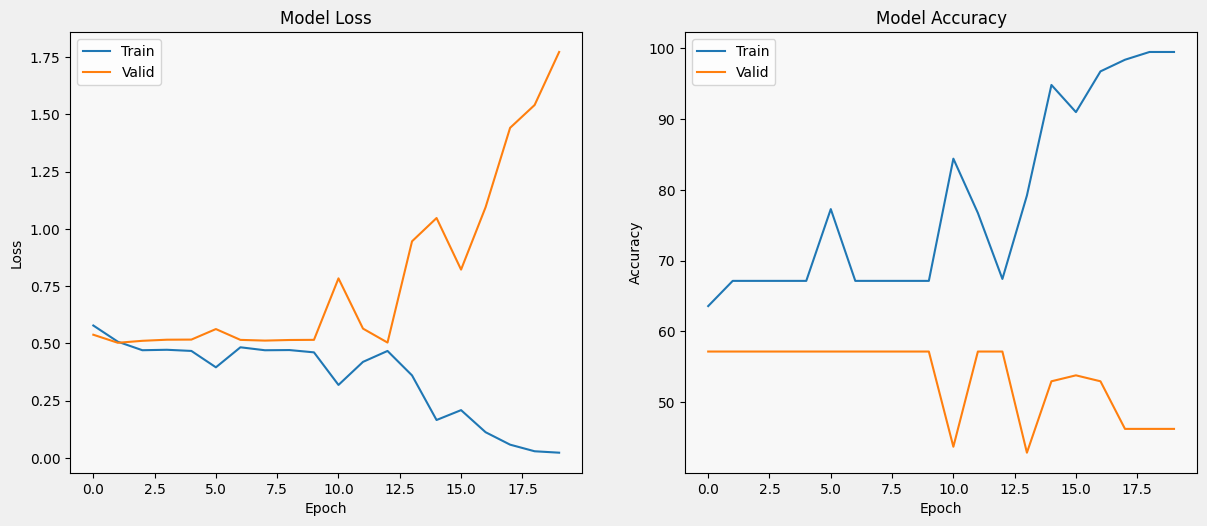

In [35]:
# Plot the training curves
display_training_curves(train_losses, valid_losses, train_accuracies, valid_accuracies, 121)

**INFERENCE (BAG LEVEL)** 

In [36]:
from sklearn.metrics import confusion_matrix

model.eval()
test_loss = 0
correct = 0
total = 0
y_true_test = []
y_pred_test = []
y_probs = []

with torch.no_grad():
    for images, labels in tqdm(test_loader):
        # Move data to GPU if available
        images = images.to(device)
        labels = labels.to(device)
        outputs_without_sigmoid, outputs_with_sigmoid = model(images)
        loss = loss_fn(outputs_without_sigmoid.squeeze(-1), labels.float())
        test_loss += loss.item()  # L+=l.item()
        predicted = (outputs_with_sigmoid >= 0.5).long().squeeze(-1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        y_true_test.extend(labels.cpu().detach().numpy())
        y_pred_test.extend(predicted.cpu().detach().numpy())
        y_probs.extend(outputs_with_sigmoid.cpu().detach().numpy())

test_loss /= len(test_loader)
test_accuracy = 100 * correct / total

# Calculate ROC-AUC for test set
fpr_test, tpr_test, _ = roc_curve(y_true_test, y_probs)
roc_auc_test = auc(fpr_test, tpr_test)

print(f'Test Accuracy: {test_accuracy:.2f}%, Test Loss: {test_loss:.2f}%')

# Classification report for test set
print("Test Classification Report:")
print(classification_report(y_true_test, y_pred_test))

100%|██████████| 11/11 [00:00<00:00, 29.10it/s]

Test Accuracy: 58.93%, Test Loss: 1.25%
Test Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.63      0.69       121
           1       0.34      0.49      0.40        47

    accuracy                           0.59       168
   macro avg       0.55      0.56      0.54       168
weighted avg       0.64      0.59      0.61       168



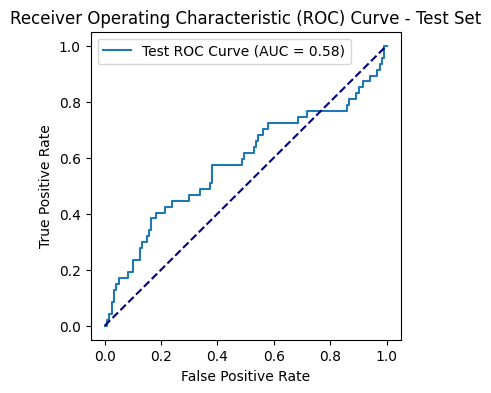

In [37]:
# ROC curve for the test set
plt.figure(figsize=(4, 4))
plt.plot(fpr_test, tpr_test, label=f'Test ROC Curve (AUC = {roc_auc_test:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Set')
plt.legend()
plt.show()

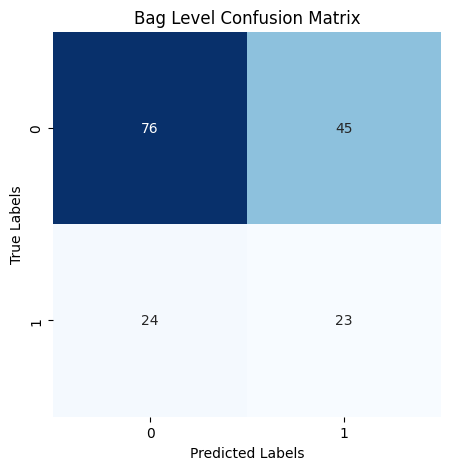

In [38]:
# Generate confusion matrix
conf_matrix = confusion_matrix(y_true_test, y_pred_test)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Bag Level Confusion Matrix')
plt.show()

In [39]:
def aggregate_labels(wsis_against_bags, anns_against_bags, labels):
    
    # dictionary to store aggregated labels
    aggregated_labels = {}
    
    for i in range(len(wsis_against_bags)):
        wsi = wsis_against_bags[i]
        annotation = anns_against_bags[i]
        label = labels[i]
        
        key = (wsi, annotation)
        
        # if there doesn't exist a value (label(s)) already against a key, create a new key in dict
        if key not in aggregated_labels:
            aggregated_labels[key] = []
        
        # if a value (label(s)) exist against a key, append the label to it
        aggregated_labels[key].append(label)
    
    final_aggregated = {}
    
    for key, labels_list in aggregated_labels.items():
        # assigning the label with the maximum count
        count_0 = 0
        count_1 = 0

        for label in labels_list:
            if label == 0:
                count_0 += 1
            elif label == 1:
                count_1 += 1

        if count_1 > count_0:
            final_aggregated[key] = 1
        else:
            final_aggregated[key] = 0
    
    return list(final_aggregated.values())

In [40]:
ann_ground_truths = aggregate_labels(test_wsis_for_bags, test_anns_for_bags, y_true_test)
ann_predictions = aggregate_labels(test_wsis_for_bags, test_anns_for_bags, y_pred_test)

In [41]:
# Classification report for test set
print("Test Classification Report:")
print(classification_report(ann_ground_truths, ann_predictions))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.75      0.67      0.71        18
           1       0.45      0.56      0.50         9

    accuracy                           0.63        27
   macro avg       0.60      0.61      0.60        27
weighted avg       0.65      0.63      0.64        27



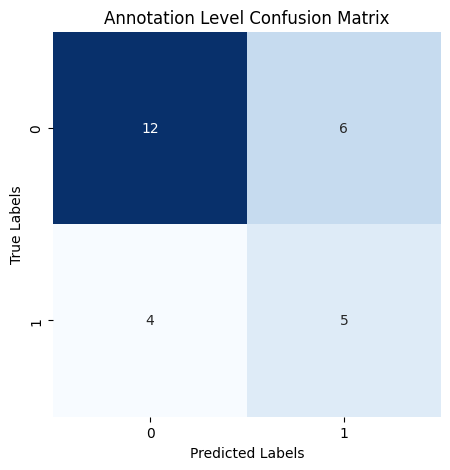

In [42]:
# Generate confusion matrix
conf_matrix = confusion_matrix(ann_ground_truths, ann_predictions)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Annotation Level Confusion Matrix')
plt.show()

In [43]:
def aggregate_wsi_level(wsis_against_bags, anns_against_bags, labels):
    
    # dictionary to store aggregated labels
    aggregated_labels = defaultdict(list)
    
    for i in range(len(wsis_against_bags)):
        wsi = wsis_against_bags[i]
        annotation = anns_against_bags[i]
        label = labels[i]
        
        key = wsi        
        # if a value (label(s)) exist against a key, append the label to it
        aggregated_labels[key].append(label)
    
    final_aggregated = {}
    
    for key, labels_list in aggregated_labels.items():
        # assigning the label with the maximum count
        count_0 = 0
        count_1 = 0

        for label in labels_list:
            if label == 0:
                count_0 += 1
            elif label == 1:
                count_1 += 1

        if count_1 > count_0:
            final_aggregated[key] = 1
        else:
            final_aggregated[key] = 0
    
    return list(final_aggregated.values())

In [44]:
wsi_ground_truths = aggregate_wsi_level(test_wsis_for_bags, test_anns_for_bags, y_true_test)
wsi_predictions = aggregate_wsi_level(test_wsis_for_bags, test_anns_for_bags, y_pred_test)

In [45]:
# Classification report for test set
print("Test Classification Report:")
print(classification_report(wsi_ground_truths, wsi_predictions))

Test Classification Report:
              precision    recall  f1-score   support

           0       0.67      1.00      0.80         2
           1       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.33      0.50      0.40         3
weighted avg       0.44      0.67      0.53         3



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


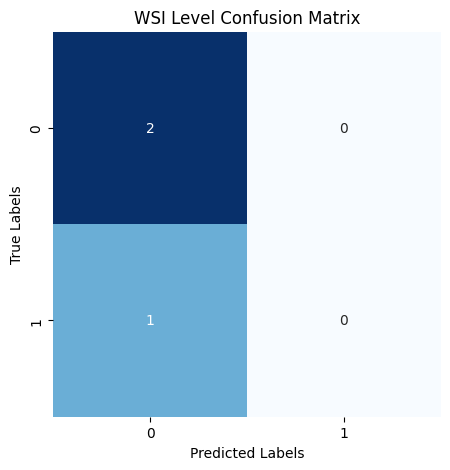

In [46]:
# Generate confusion matrix
conf_matrix = confusion_matrix(wsi_ground_truths, wsi_predictions)

# Plot confusion matrix
plt.figure(figsize=(5, 5))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('WSI Level Confusion Matrix')
plt.show()